In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import PIL
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import time

In [2]:
# Dataset location
DATASET_PATH = "Datasets/electronic-components-png"

# resolution of images
TARGET_WIDTH = 28
TARGET_HEIGHT = 28

# invert image
INVERT = False

# Grayscale
GRAYSCALE = True

# 20%-validation, 20%-test
VAL_RATIO = 0.2
TEST_RATIO = 0.2
TRAIN_RATIO = 1 - VAL_RATIO - TEST_RATIO 

# Normalization mean
MEAN = (0.0864, 0.3011, 0.6495)
STD = (1.212, 1.425, 1.505)

GRAY_MEAN = 0.5
GRAY_STD = 0.5

# Hyperparameters
LR = 0.001
EPOCHS = 10
BATCH_SIZE = 10


In [3]:
# Load and prepare dataset
def load_dataset(path, grayscale=True, invert=False):
    data = []
    class_names = []
    class_map = {}
    
    # Walk through the dataset directory to collect images and labels
    for root, dirs, files in os.walk(path):
        # Skip the root directory itself (only process subdirectories)
        if root == path:
            continue
        
        # Get label from directory name
        label = os.path.basename(root)
        
        # Add label to class_map if not already present
        if label not in class_map:
            class_map[label] = len(class_map)
            class_names.append(label)
        
        # Process each image file
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(root, file)
                data.append((img_path, class_map[label]))
    
    return data, class_names, class_map


In [4]:
# Load all data
all_data, class_names, class_map = load_dataset(DATASET_PATH, grayscale=GRAYSCALE, invert=INVERT)

# Print class information
print(f"Found {len(class_names)} unique classes:")
for i, label in enumerate(sorted(class_names)):
    count = sum(1 for _, class_id in all_data if class_id == i)
    print(f"{i}: {label} (Count: {count})")

Found 5 unique classes:
0: background (Count: 50)
1: capacitor (Count: 50)
2: diode (Count: 50)
3: led (Count: 50)
4: resistor (Count: 50)


In [5]:
# Split dataset
train_val_data, test_data = train_test_split(all_data, test_size=TEST_RATIO, random_state=42)
train_data, val_data = train_test_split(train_val_data, test_size=VAL_RATIO/(1-TEST_RATIO), random_state=42)

In [6]:
# Data augmentation and preprocessing
def preprocess_image(image_path, label, grayscale=GRAYSCALE, invert=INVERT):
    # Read image file
    image = tf.io.read_file(image_path)
    # Decode image
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    # Resize
    image = tf.image.resize(image, [TARGET_HEIGHT, TARGET_WIDTH])
    
    if grayscale:
        # Convert to grayscale
        image = tf.image.rgb_to_grayscale(image)
        # Normalize
        image = (image / 255.0 - GRAY_MEAN) / GRAY_STD
    else:
        # Normalize RGB
        image = (image / 255.0 - MEAN) / STD
    
    if invert:
        image = 1.0 - image
    
    return image, label

In [7]:
# Create TensorFlow datasets
def create_dataset(data, batch_size=BATCH_SIZE, shuffle=False):
    image_paths = [item[0] for item in data]
    labels = [item[1] for item in data]
    
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: preprocess_image(x, y, GRAYSCALE, INVERT))
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(data))
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

In [8]:
train_dataset = create_dataset(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = create_dataset(val_data, batch_size=BATCH_SIZE)
test_dataset = create_dataset(test_data, batch_size=BATCH_SIZE)

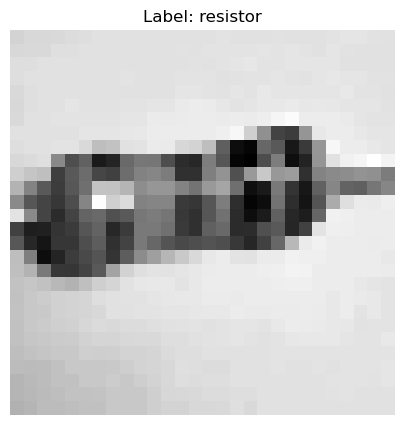

In [9]:
# Visualize a sample
def visualize_sample(dataset):
    for images, labels in dataset.take(1):
        plt.figure(figsize=(5, 5))
        image = images[0].numpy()
        if GRAYSCALE:
            # Denormalize
            image = (image * GRAY_STD + GRAY_MEAN) * 255
            image = np.clip(image, 0, 255).astype('uint8')
            plt.imshow(image.squeeze(), cmap='gray')
        else:
            # Denormalize RGB
            image = (image * STD + MEAN) * 255
            image = np.clip(image, 0, 255).astype('uint8')
            plt.imshow(image)
        plt.title(f"Label: {class_names[labels[0]]}")
        plt.axis('off')
        plt.show()

visualize_sample(train_dataset)

In [10]:
# Define the model
def create_model(input_shape=(28, 28, 1), num_classes=5):
    model = keras.Sequential([
        layers.Conv2D(32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=2),
        layers.Dropout(0.4),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model


In [11]:
# Create model
if GRAYSCALE:
    model = create_model(input_shape=(28, 28, 1), num_classes=len(class_names))
else:
    model = create_model(input_shape=(28, 28, 3), num_classes=len(class_names))

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LR),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               802944    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [12]:
# Callbacks
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss'),
    keras.callbacks.TensorBoard(log_dir=f'logs/{time.strftime("%Y%m%d-%H%M%S")}', histogram_freq=1)
]

# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=callbacks
)

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.4f}")

Epoch 1/10
15/15 [==============================] - 6s 27ms/step - loss: 1.8265 - accuracy: 0.6133 - val_loss: 1.2839 - val_accuracy: 0.7200
Epoch 2/10
15/15 [==============================] - 0s 10ms/step - loss: 0.4945 - accuracy: 0.8467 - val_loss: 1.2675 - val_accuracy: 0.5400
Epoch 3/10
15/15 [==============================] - 0s 10ms/step - loss: 0.5319 - accuracy: 0.8600 - val_loss: 1.2209 - val_accuracy: 0.8400
Epoch 4/10
15/15 [==============================] - 0s 10ms/step - loss: 0.0870 - accuracy: 0.9733 - val_loss: 1.1715 - val_accuracy: 0.9000
Epoch 5/10
15/15 [==============================] - 0s 12ms/step - loss: 0.1016 - accuracy: 0.9800 - val_loss: 1.1112 - val_accuracy: 0.9200
Epoch 6/10
15/15 [==============================] - 0s 8ms/step - loss: 0.0883 - accuracy: 0.9667 - val_loss: 1.0642 - val_accuracy: 0.9400
Epoch 7/10
15/15 [==============================] - 0s 9ms/step - loss: 0.0190 - accuracy: 1.0000 - val_loss: 1.0013 - val_accuracy: 0.9200
Epoch 8/10
15/1

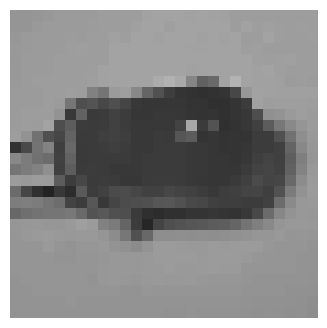


Model output (raw predictions):
background     : 0.0476
capacitor      : 0.1408
diode          : 0.1093
led            : 0.6149
resistor       : 0.0873

Prediction summary:
Predicted label: 3 - led
Actual label:    3 - led
Confidence:      61.5%

✅ Correct prediction!


In [ ]:
# Get one sample from validation set
for sample_image, sample_label in val_dataset.unbatch().skip(20).take(1):
    break

# Prepare input (add batch dimension)
input_image = np.expand_dims(sample_image, axis=0)

# Make prediction
y_pred = model.predict(input_image)
predicted_label = np.argmax(y_pred, axis=1)[0]
actual_label = sample_label.numpy()

# Get class names (from your earlier class_map)
labels = sorted(class_map.keys())  # List of class names in order

# Visualize the sample
plt.figure(figsize=(8, 4))
if GRAYSCALE:
    # Denormalize grayscale image
    denormalized = (sample_image * GRAY_STD + GRAY_MEAN).numpy().squeeze()
    plt.imshow(denormalized, cmap='gray', vmin=0, vmax=1)
else:
    # Denormalize RGB image
    denormalized = (sample_image * STD + MEAN).numpy()
    denormalized = np.clip(denormalized, 0, 1)
    if denormalized.shape[0] == 3:  # CHW to HWC
        denormalized = denormalized.transpose(1, 2, 0)
    plt.imshow(denormalized)

plt.axis('off')
plt.show()

# Display prediction info
print("\nModel output (raw predictions):")
for i, score in enumerate(y_pred[0]):
    print(f"{labels[i]:<15}: {score:.4f}")

print("\nPrediction summary:")
print(f"Predicted label: {predicted_label} - {labels[predicted_label]}")
print(f"Actual label:    {actual_label} - {labels[actual_label]}")
print(f"Confidence:      {np.max(y_pred)*100:.1f}%")

# Show whether prediction was correct
if predicted_label == actual_label:
    print("\n✅ Correct prediction!")
else:
    print("\n❌ Incorrect prediction")